In [67]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from tqdm import tqdm
from matplotlib import pyplot as plt

from networks.cnn import CNN
from attacks.fgsm import FGSMTransform, ToTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [6]:
from PIL import Image
class CustomCIFAR(datasets.CIFAR10):
    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            #CHANGED from the torchvision implementation: pass the target into transform
            img = self.transform((img, target))
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

In [66]:
import torch
from networks.cnn import CNN
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fast gradient sign method
def fgsm(image, epsilon, data_grad):
    """Generate a perturbed image using the Fast Gradient Sign Method."""
    # eta = epsilon * sign(gradient of loss w.r.t input image)
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


def simple_test(test_loader, criterion, model):
    model.to(device)
    model.eval()
    losses = []
    accuracies = []
    for inputs, labels in test_loader:
        # for every batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        accuracy = (torch.max(outputs, dim=1)[1] == labels).to(torch.float32).mean()
        losses.append(loss.cpu().detach().numpy())
        accuracies.append(accuracy.cpu().numpy())

    loss, accuracy = np.mean(losses), np.mean(accuracies)

    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
    return loss, accuracy


def test_pre_post_fgsm(
    model, test_dataset, test_loader, epsilon, criterion
):
    """this function runs the model and compares the outputs with and without fgsm attack"""
    correct = 0
    adv_examples = []
    for images, labels in test_loader:
        # Send the data and label to the device
        images, labels = images.to(device), labels.to(device)

        # Set requires_grad attribute of tensor
        images.requires_grad = True

        # Forward pass the data through the model
        output = model(images)
        # get the index of the max log-probability
        init_pred = torch.max(output, dim=1)[1]
        loss = criterion(output, labels)

        model.zero_grad()
        loss.backward()

        # Collect gradients
        data_grad = images.grad.data

        # Call FGSM Attack
        perturbed_images = fgsm(images, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_images)

        final_pred = torch.max(output, dim=1)[
            1
        ]  # get the index of the max log-probability
        correct_idx = final_pred == labels
        correct += sum(correct_idx.to(torch.float32)).item()

        # only get pred that was right buut now wrong
        incorrect_idx = (final_pred != labels) & (init_pred == labels)

        # saving examples of perturbed images for later visualization
        if len(adv_examples) < 5:
            # Save some adv examples for visualization later
            # p is the single perturbed image, y is the correct label, initial and final and pre- and post-fgsm predictions
            for initial, final, p, y in zip(
                init_pred[incorrect_idx],
                final_pred[incorrect_idx],
                perturbed_images[incorrect_idx],
                labels[incorrect_idx],
            ):
                adv_ex = p.squeeze().detach().cpu().numpy()
                adv_examples.append((initial.item(), final.item(), y.item(), adv_ex))
                # returned adv_examples is 1 x batchsize x 4, holding items: pre-fgsm pred, post-fgsm pred, ground truth, post-fgsm image

            # Special case for saving 0 epsilon examples
            if epsilon == 0:
                for initial, final in zip(
                    init_pred[correct_idx], final_pred[correct_idx]
                ):
                    adv_ex = perturbed_images.squeeze().detach().cpu().numpy()
                    adv_examples.append(
                        (initial.item(), final.item(), final.item(), adv_ex)
                    )

    data_len = len(test_dataset)
    # Calculate final accuracy for this epsilon
    final_acc = correct / float(data_len)
    print(
        "Epsilon: {}\tTest Accuracy = {} / {} = {}".format(
            epsilon, correct, data_len, final_acc
        )
    )
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


In [118]:
transform = transforms.Compose([transforms.ToTensor()])
fgsm_transform = transforms.Compose([ToTensor(),FGSMTransform(0.3)])

# Download CIFAR10 dataset

train_dataset1 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataset2 = CustomCIFAR(root='./data', train=True, transform=fgsm_transform)
augmented_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2])
# Create data loaders
mini_train_idx = torch.utils.data.SubsetRandomSampler(np.arange(2000)) # get smaller dataset of 1000 images
mini_train_loader = torch.utils.data.DataLoader(dataset=augmented_dataset, batch_size=64, sampler=mini_train_idx)
train_loader= torch.utils.data.DataLoader(dataset=augmented_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [119]:
# Create the model
model = CNN().to(device)
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10

In [120]:
# Train the model
progress = tqdm(total=len(train_loader)*EPOCHS, desc="Training") # add a progress bar
for epoch in range(EPOCHS):
    for images, labels in train_loader:
        model.train()
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress.update(1)
    
    progress.write(f'Epoch [{epoch+1}/{10}], Loss: {loss.item():.4f}')

# #saving model
torch.save(model.state_dict(), "cnn_fgsm2.pth")

Training:  10%|█         | 1564/15630 [02:22<20:06, 11.66it/s]

Epoch [1/10], Loss: 0.6551


Training:  20%|██        | 3128/15630 [04:47<19:10, 10.86it/s]

Epoch [2/10], Loss: 0.6505


Training:  30%|███       | 4691/15630 [07:12<15:44, 11.58it/s]

Epoch [3/10], Loss: 0.3792


Training:  40%|████      | 6254/15630 [09:33<13:01, 12.00it/s]

Epoch [4/10], Loss: 0.3812


Training:  50%|█████     | 7815/15630 [11:55<10:49, 12.04it/s]

Epoch [5/10], Loss: 0.4212


Training:  60%|██████    | 9380/15630 [14:18<08:57, 11.64it/s]

Epoch [6/10], Loss: 0.1743


Training:  70%|███████   | 10943/15630 [16:41<06:49, 11.44it/s]

Epoch [7/10], Loss: 0.2589


Training:  80%|████████  | 12505/15630 [19:00<04:26, 11.74it/s]

Epoch [8/10], Loss: 0.3233


Training:  90%|█████████ | 14069/15630 [21:21<02:12, 11.75it/s]

Epoch [9/10], Loss: 0.3571


Training: 100%|██████████| 15630/15630 [23:42<00:00, 10.66it/s]

Epoch [10/10], Loss: 0.3017


Training: 100%|██████████| 15630/15630 [23:52<00:00, 10.66it/s]

In [107]:
def compare_test(base_path, title):
    """given two models, compare how they do under different epsilons of fgsm attack"""
    #testing our trained model
    # fgsm_model = CNN().to(device)
    # fgsm_model.load_state_dict(torch.load(fgsm_path))
    base_model = CNN().to(device)
    base_model.load_state_dict(torch.load(base_path))

    criterion = torch.nn.CrossEntropyLoss()

    epsilons = [0, 0.003, 0.005, 0.007, 0.01, 0.015, 0.02, 0.04, 0.08, 0.1]
    # accuracies_fgsm = []
    # losses_fgsm = []
    accuracies = []
    losses = []
    for e in epsilons:
        transform_fgsm = transforms.Compose([
                ToTensor(),
                FGSMTransform(epsilon=e) #epsilon
            ])
        fgsm_test = CustomCIFAR(root='./data', train=False, transform=transform_fgsm)
        fgsm_loader = torch.utils.data.DataLoader(dataset=fgsm_test, batch_size=64)
        # print("testing cnn with fgsm-attacked images, epsilon=",e)
        l, a = simple_test(test_loader=fgsm_loader, criterion=criterion, model=base_model)
        accuracies.append(a)
        losses.append(l)
        # l, a = simple_test(test_loader=fgsm_loader, criterion=criterion, model=fgsm_model)
        # accuracies_fgsm.append(a)
        # losses_fgsm.append(l)
    #plotting results
    # plt.plot(epsilons, accuracies, "o-", label="Base Model")
    # plt.plot(epsilons, accuracies_fgsm, "o-",label="Augmented model")
    # plt.title(title+ " - Accuracy")
    # plt.xlabel("Epsilon")
    # plt.ylabel("Accuracy")
    # plt.legend()
    # plt.show()
    # plt.plot(epsilons, losses, "o-",label="Base model")
    # plt.plot(epsilons, losses_fgsm, "o-", label="Augmented model")
    # plt.title(title+" - Loss")
    # plt.xlabel("Epsilon")
    # plt.ylabel("Loss")
    # plt.legend()
    # plt.show()
    print("Base model accuracies:", accuracies)
    return accuracies, losses
    # print("Augmented model accuracies:", accuracies_fgsm)

testing cnn with fgsm-attacked images, epsilon= 0
Loss: 0.8124, Accuracy: 0.7251
Loss: 1.5999, Accuracy: 0.6486
testing cnn with fgsm-attacked images, epsilon= 0.003
Loss: 0.8522, Accuracy: 0.7124
Loss: 1.5826, Accuracy: 0.6504
testing cnn with fgsm-attacked images, epsilon= 0.005
Loss: 0.8802, Accuracy: 0.7032
Loss: 1.5731, Accuracy: 0.6542
testing cnn with fgsm-attacked images, epsilon= 0.007
Loss: 0.9091, Accuracy: 0.6943
Loss: 1.5649, Accuracy: 0.6569
testing cnn with fgsm-attacked images, epsilon= 0.01
Loss: 0.9546, Accuracy: 0.6802
Loss: 1.5551, Accuracy: 0.6616
testing cnn with fgsm-attacked images, epsilon= 0.015
Loss: 1.0362, Accuracy: 0.6560
Loss: 1.5459, Accuracy: 0.6649
testing cnn with fgsm-attacked images, epsilon= 0.02
Loss: 1.1257, Accuracy: 0.6255
Loss: 1.5466, Accuracy: 0.6640
testing cnn with fgsm-attacked images, epsilon= 0.04
Loss: 1.5695, Accuracy: 0.5096
Loss: 1.6572, Accuracy: 0.6491
testing cnn with fgsm-attacked images, epsilon= 0.08
Loss: 2.7140, Accuracy: 0.

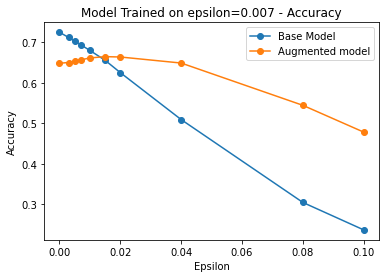

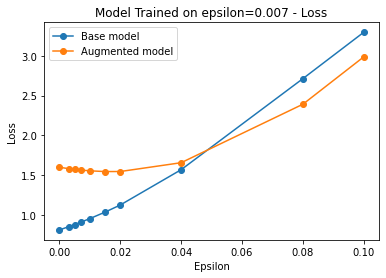

In [92]:
compare_test(fgsm_path="./models/cnn_fgsm007.pth", base_path="./models/cnn.pth",title="Model Trained on epsilon=0.007")

In [108]:
accuracies[0.01],_ = compare_test(base_path="./models/cnn_fgsm01.pth",title="Model Trained on epsilon=0.01")

Loss: 1.5844, Accuracy: 0.6469
Loss: 1.4276, Accuracy: 0.6759
Loss: 1.3383, Accuracy: 0.6928
Loss: 1.2596, Accuracy: 0.7068
Loss: 1.1607, Accuracy: 0.7280
Loss: 1.0377, Accuracy: 0.7550
Loss: 0.9532, Accuracy: 0.7688
Loss: 0.8616, Accuracy: 0.7896
Loss: 1.2382, Accuracy: 0.7221
Loss: 1.5920, Accuracy: 0.6707
Base model accuracies: [0.64689493, 0.6758559, 0.69277465, 0.7068073, 0.7280056, 0.7549761, 0.76880974, 0.78960985, 0.72213376, 0.67068076]


Loss: 1.4680, Accuracy: 0.6300
Loss: 1.2395, Accuracy: 0.6821
Loss: 1.1137, Accuracy: 0.7118
Loss: 1.0069, Accuracy: 0.7392
Loss: 0.8766, Accuracy: 0.7674
Loss: 0.7201, Accuracy: 0.8054
Loss: 0.6156, Accuracy: 0.8317
Loss: 0.4589, Accuracy: 0.8710
Loss: 0.6950, Accuracy: 0.8225
Loss: 1.0119, Accuracy: 0.7678
Base model accuracies: [0.6299761, 0.6821258, 0.71178347, 0.7391521, 0.7674164, 0.8054339, 0.8317078, 0.8710191, 0.82245225, 0.7678145]


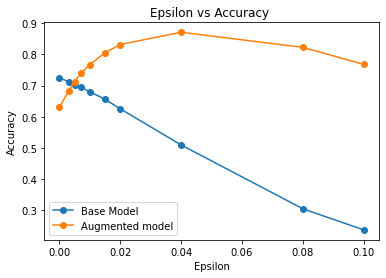

In [106]:
epsilons = [0, 0.003, 0.005, 0.007, 0.01, 0.015, 0.02, 0.04, 0.08, 0.1]
accuracies = {}
# accuracies[0.015],_ = compare_test(base_path="./models/cnn_fgsm015.pth",title="Model Trained on epsilon=0.015")
accuracies[0.015] = [0.63,0.68,0.7118,0.7392,0.7674,0.8054,0.8317]
accuracies[0.007] = [0.6486, 0.6504, 0.6542, 0.6569, 0.6616, 0.6649, 0.6640, 0.6491, 0.5447, 0.4785]
accuracies[0] = [0.7251, 0.7124, 0.7032, 0.6943, 0.6802, 0.6560, 0.6255, 0.5096, 0.3049, 0.2372] #base model copied from an iteration before
accuracies[0.01] = [0.64689493, 0.6758559, 0.69277465, 0.7068073, 0.7280056, 0.7549761, 0.76880974, 0.78960985, 0.72213376, 0.67068076]

In [116]:
accuracies[0.5],_ = compare_test(base_path="./models/cnn_fgsm5.pth",title="Model Trained on epsilon=0.05")

Loss: 1.0507, Accuracy: 0.6560
Loss: 1.0619, Accuracy: 0.6515
Loss: 1.0698, Accuracy: 0.6486
Loss: 1.0780, Accuracy: 0.6458
Loss: 1.0906, Accuracy: 0.6416
Loss: 1.1122, Accuracy: 0.6329
Loss: 1.1340, Accuracy: 0.6279
Loss: 1.2168, Accuracy: 0.6030
Loss: 1.2294, Accuracy: 0.6075
Loss: 1.1175, Accuracy: 0.6416
Base model accuracies: [0.65595144, 0.6514729, 0.6485868, 0.6458002, 0.6416202, 0.63286227, 0.6278862, 0.6030056, 0.6074841, 0.6416202]


In [121]:
accuracies[0.2],_ = compare_test(base_path="./models/cnn_fgsm2.pth",title="Model Trained on epsilon=0.02")

Loss: 0.9914, Accuracy: 0.6683
Loss: 1.0000, Accuracy: 0.6663
Loss: 1.0062, Accuracy: 0.6657
Loss: 1.0127, Accuracy: 0.6644
Loss: 1.0227, Accuracy: 0.6602
Loss: 1.0406, Accuracy: 0.6543
Loss: 1.0587, Accuracy: 0.6498
Loss: 1.1229, Accuracy: 0.6322
Loss: 1.0174, Accuracy: 0.6692
Loss: 0.8086, Accuracy: 0.7406
Base model accuracies: [0.6682922, 0.6663017, 0.6657046, 0.6644108, 0.6602309, 0.65425956, 0.64978105, 0.6321656, 0.6691879, 0.74064493]


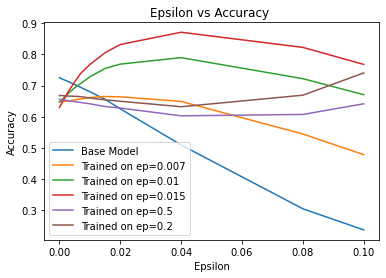

In [123]:
plt.plot(epsilons, accuracies[0], "-", label="Base Model")
plt.plot(epsilons,accuracies[0.007], "-",label="Trained on ep=0.007")
plt.plot(epsilons,accuracies[0.01], "-",label="Trained on ep=0.01")
plt.plot(epsilons, accuracies[0.015], "-",label="Trained on ep=0.015")
plt.plot(epsilons,accuracies[0.5], "-",label="Trained on ep=0.5")
plt.plot(epsilons,accuracies[0.2], "-",label="Trained on ep=0.2")
plt.title("Epsilon vs Accuracy ")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

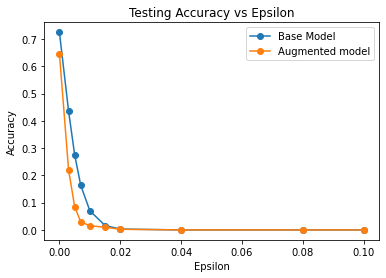

In [80]:
#this was trained with pre_post_fgsm testing, and the augmented model was trained with eps = 0.005
plt.plot(epsilons, accuracies2, "o-", label="Base Model")
plt.plot(epsilons, accuracies_fgsm2, "o-",label="Augmented model")
plt.title("Testing Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
#training a model with batchsize=1 on original images to fix dimension errors in the transform of fgsm
train_loader_bs1 = torch.utils.data.DataLoader(dataset=train_dataset1, batch_size=1, shuffle=True)

# fgsm_train = CustomCIFAR(root='./data', train=True, transform=transform_fgsm)
# fgsm_loader = torch.utils.data.DataLoader(dataset=fgsm_train, batch_size=1, shuffle=True)

model_batchsize1 = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_batchsize1.parameters(), lr=0.001)
EPOCHS = 10
# Train the model
progress = tqdm(total=len(train_loader_bs1)*EPOCHS, desc="Training") # add a progress bar
for epoch in range(EPOCHS):
    for images, labels in train_loader_bs1:
        model_batchsize1.train()
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_batchsize1(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress.update(1)
    
    progress.write(f'Epoch [{epoch+1}/{10}], Loss: {loss.item():.4f}')

# #saving model
# torch.save(model_batchsize1.state_dict(), "./models/cnn_batchsize1.pth")
# print("Saved PyTorch Model State as cnn_batchsize1.pth")

Training:  10%|█         | 50080/500000 [02:03<17:42, 423.45it/s]

Epoch [1/10], Loss: 0.4207


Training:  20%|██        | 100031/500000 [04:04<16:46, 397.34it/s]

Epoch [2/10], Loss: 1.7742


Training:  30%|███       | 150050/500000 [06:01<13:45, 423.80it/s]

Epoch [3/10], Loss: 0.0344


Training:  40%|████      | 200077/500000 [08:05<12:51, 388.92it/s]

Epoch [4/10], Loss: 2.3964


Training:  50%|█████     | 250071/500000 [10:10<10:28, 397.82it/s]

Epoch [5/10], Loss: 0.8319


Training:  60%|██████    | 300064/500000 [12:10<07:51, 424.21it/s]

Epoch [6/10], Loss: 0.1605


Training:  70%|███████   | 350076/500000 [14:12<06:01, 414.27it/s]

Epoch [7/10], Loss: 2.3115


Training:  80%|████████  | 400063/500000 [16:12<04:06, 405.97it/s]

Epoch [8/10], Loss: 0.0240


Training:  90%|█████████ | 450073/500000 [18:14<02:01, 412.30it/s]

Epoch [9/10], Loss: 1.0772


Training: 100%|██████████| 500000/500000 [20:14<00:00, 407.79it/s]

Epoch [10/10], Loss: 0.0304


Training: 100%|██████████| 500000/500000 [20:30<00:00, 407.79it/s]

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
simple_test(test_loader, criterion, "./models/cnn_batchsize1test.pth")
test_pre_post_fgsm(test_loader=test_loader, model=model_batchsize1, test_dataset_len=len(test_dataset), criterion=criterion, epsilon=0)
test_pre_post_fgsm(test_loader=test_loader, model=model_batchsize1, test_dataset_len=len(test_dataset), criterion=criterion, epsilon=0.005)

Everything below this is a little outdated, but keep it here for notes

In [22]:
# Adversarial test

epsilons = [0, 0.0005, 0.001, 0.003, 0.007,0.01]
pretrained_model = "models/cnn.pth"
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network
model = CNN().to(device)
model.load_state_dict(torch.load(pretrained_model))
# Set the model in evaluation mode. In this case this is for the Dropout layers
model = model_batchsize1
model.eval()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


accuracies = []
examples = []

epsilons = [0, 0.001, 0.003, 0.005, 0.007, 0.1, 0.15] #overwriting epsilon for faster testing
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_pre_post_fgsm(model, device, len(test_dataset), test_loader, eps, criterion)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 2095.0 / 10000 = 0.2095
Epsilon: 0.001	Test Accuracy = 1583.0 / 10000 = 0.1583
Epsilon: 0.003	Test Accuracy = 894.0 / 10000 = 0.0894
Epsilon: 0.005	Test Accuracy = 493.0 / 10000 = 0.0493
Epsilon: 0.007	Test Accuracy = 246.0 / 10000 = 0.0246


KeyboardInterrupt: 

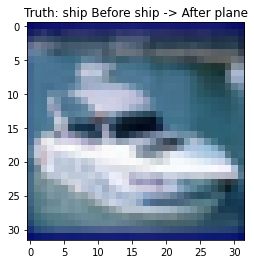

In [9]:
# print an adversarial example saved during the above program
import matplotlib.pyplot as plt
import torchvision

#img needs to be a tensor that is configured with torchvision.utils.make_grid(img), before after and truth are strings
def imshow(img, truth, before="", after=""):
    npimg = torchvision.utils.make_grid(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Truth: {} Before {} -> After {}".format(truth, before, after))
    plt.show()

ex = examples[1][3]
img = torch.tensor(ex[3])
# perturbed image
imshow(img, classes[ex[2]], classes[ex[0]], classes[ex[1]])

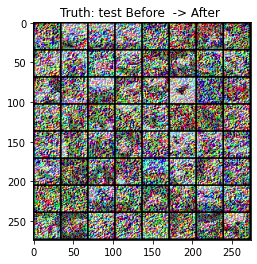

In [10]:
transform = transforms.Compose([
        ToTensor(),
        FGSMTransform(epsilon=0.5) #epsilon
    ])

mini_set = CustomCIFAR(root='./data', train=False, transform=transform)
mini_loader = torch.utils.data.DataLoader(dataset=mini_set, batch_size=64)
for images, l in mini_loader:
    #show the first batch of images. epsilon was very high hence images are very fgsm-y
    imshow(torch.tensor(images.squeeze().detach().cpu().numpy()), "test")
    break


In [201]:

transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
criterion = torch.nn.CrossEntropyLoss()
print("testing original CNN")
testing(test_loader,criterion=criterion, model_path = "models/cnn.pth")

epsilons = [0, 0.003, 0.005, 0.007, 0.01, 0.015, 0.02, 0.04, 0.08,0.1]
accuracies = []
losses = []
for e in epsilons:
    transform = transforms.Compose([
            ToTensor(),
            FGSMTransform(epsilon=e) #epsilon
        ])
    fgsm_test = CustomCIFAR(root='./data', train=False, transform=transform)
    fgsm_loader = torch.utils.data.DataLoader(dataset=fgsm_test, batch_size=64)
    print("testing cnn with fgsm-attacked images, epsilon=",e)
    l, a = testing(test_loader=fgsm_loader, criterion=criterion, model_path= "models/cnn.pth")
    accuracies.append(a)
    losses.append(l)
#good news is that epsilon=0 and using our original cnn.pth model results in the same accuracy, so the data aug was done correctly!


testing original CNN
Loss: 0.8124, Accuracy: 0.7251
testing cnn with fgsm-attacked images, epsilon= 0
Loss: 0.8124, Accuracy: 0.7251
testing cnn with fgsm-attacked images, epsilon= 0.003
Loss: 1.8583, Accuracy: 0.4364
testing cnn with fgsm-attacked images, epsilon= 0.005
Loss: 2.7590, Accuracy: 0.2756
testing cnn with fgsm-attacked images, epsilon= 0.007
Loss: 3.7399, Accuracy: 0.1635
testing cnn with fgsm-attacked images, epsilon= 0.01
Loss: 5.2370, Accuracy: 0.0702
testing cnn with fgsm-attacked images, epsilon= 0.015
Loss: 7.5590, Accuracy: 0.0163
testing cnn with fgsm-attacked images, epsilon= 0.02
Loss: 9.5388, Accuracy: 0.0031
testing cnn with fgsm-attacked images, epsilon= 0.04
Loss: 14.5693, Accuracy: 0.0000
testing cnn with fgsm-attacked images, epsilon= 0.08
Loss: 17.6972, Accuracy: 0.0000
testing cnn with fgsm-attacked images, epsilon= 0.1
Loss: 18.0084, Accuracy: 0.0000


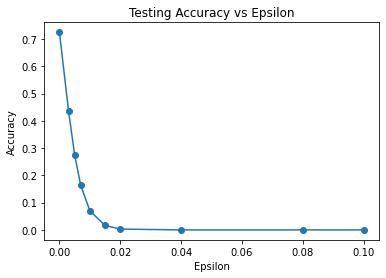

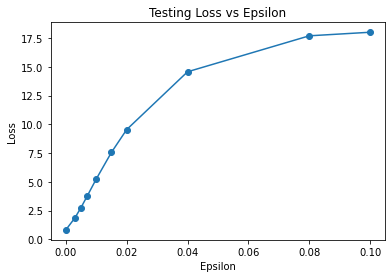

In [217]:
plt.plot(epsilons, accuracies, "o-")
plt.title("Testing Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()
plt.plot(epsilons, losses, "o-")
plt.title("Testing Loss vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Loss")
plt.show()

In [12]:
#training with adversarial examples
transform_normal = transforms.Compose([transforms.ToTensor()])
transform_fgsm = transforms.Compose([
            ToTensor(),
            FGSMTransform(epsilon=0.005, prob=1) #epsilon
        ])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_normal)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
# model_normal = CNN().to(device)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

fgsm_dataset = CustomCIFAR(root='./data', train=True, transform=transform_fgsm)
fgsm_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
model_fgsm = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fgsm.parameters(), lr=0.001)

# Train the model
progress = tqdm(total=2*len(fgsm_loader)*EPOCHS, desc="Training") # add a progress bar
for epoch in range(EPOCHS):
    loaders =[train_loader, fgsm_loader]
    for loader in loaders:
        for images, labels in loader:
            model_fgsm.train()
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_fgsm(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress.update(1)
    
    progress.write(f'Epoch [{epoch+1}/{10}], Loss: {loss.item():.4f}')
# torch.save(model_fgsm.state_dict(), "./models/cnn_fgsm.pth")

Training: 100%|██████████| 2000/2000 [15:32<00:00,  2.14it/s] 


KeyboardInterrupt: 

In [236]:
#testing on normal CIFAR 10 data set with model trained on fgsm data
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_normal)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)
testing(test_loader=test_loader, criterion=criterion, model_path= "models/cnn_fgsm.pth")
testing(test_loader=test_loader, criterion=criterion, model_path= "models/cnn.pth")

Loss: 1.6422, Accuracy: 0.6536
Loss: 0.8125, Accuracy: 0.7254


(0.8124636, 0.725418)